In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('Student_Performance.csv')

data['Extracurricular Activities'] = data['Extracurricular Activities'].map({'Yes': 1, 'No': 0})
data.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


In [3]:
x_data = data.drop('Performance Index', axis=1)
y_data = data['Performance Index']

x_features = x_data.columns.to_list()
print(x_features)

['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']


In [4]:
x_train = x_data.values
y_train = y_data.values

number_of_features = x_train.shape[1]
print(f"Shape of features array: {number_of_features}")

length = len(y_train)
print(f"Length of the data: {length}")

Shape of features array: 5
Length of the data: 10000


In [5]:
w_initial = np.array([30, 30, 5, 15, 20])
b_initial = 10

In [6]:
def z_score_normalization(x, number_of_features):
    x_norm = np.copy(x)
    for i in range(number_of_features):
        feature = x_norm[:,i]
        mean_i = np.mean(feature, axis=0)
        standard_deviation_i = np.std(feature, axis=0)
        x_norm[:,i] = (feature - mean_i) / standard_deviation_i
    return x_norm

In [7]:
def compute_f_wb(w, x, b, length):
    f_wb = np.zeros(length, dtype=float)
    for i in range(length):
        f_wb[i] = np.dot(w, x[i]) + b
        if f_wb[i] > 100:
            f_wb[i] = 100
        elif f_wb[i] < 0:
            f_wb[i] = 0
    return f_wb

In [8]:
x_norm = z_score_normalization(x_train, number_of_features)
f_wb = compute_f_wb(w_initial, x_norm, b_initial, length)
print(f"First 10 predicted values: {f_wb[:10]}")
print(f"First 10 actual values:    {y_train[:10]}")

First 10 predicted values: [40.  0. 15.  0. 10. 25. 15.  0. 10.  5.]
First 10 actual values:    [91. 65. 45. 36. 66. 61. 63. 42. 61. 69.]


In [9]:
def draw_function(x, y, f_wb, number_of_features, features):
    for i in range(number_of_features):
        plt.scatter(x[:,i], y, marker='o', c='r', label='Actual Data')

        sorted_indices = np.argsort(x[:, i])
        x_sorted = x[sorted_indices, i]
        f_wb_sorted = f_wb[sorted_indices]

        plt.plot(x_sorted, f_wb_sorted, c='b', label='Predicted Data')
        plt.title(f"{features[i]} vs Performance Index")
        plt.xlabel(features[i])
        plt.ylabel('Performance Index')
        plt.legend()
        plt.show()

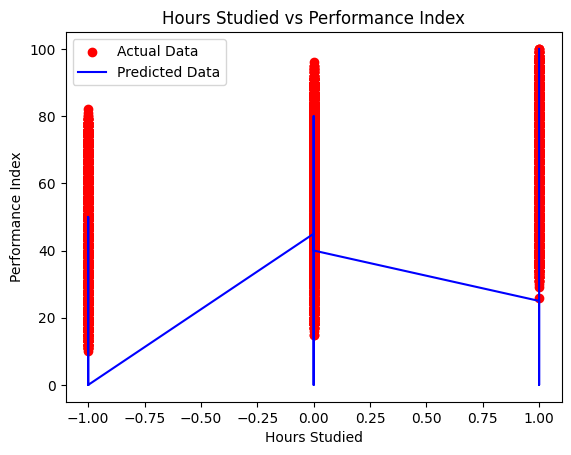

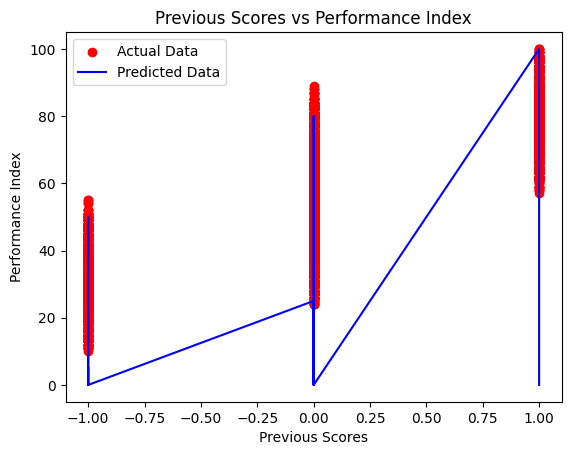

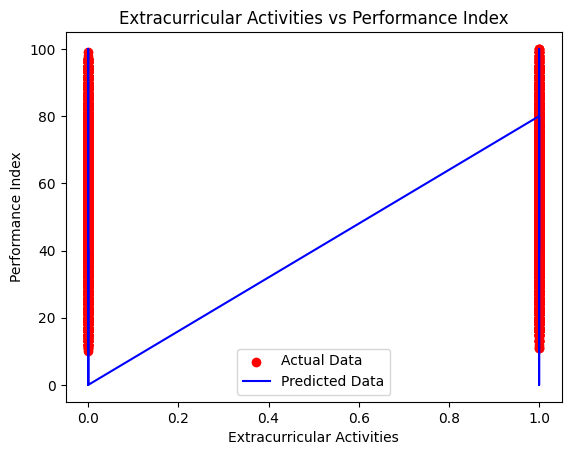

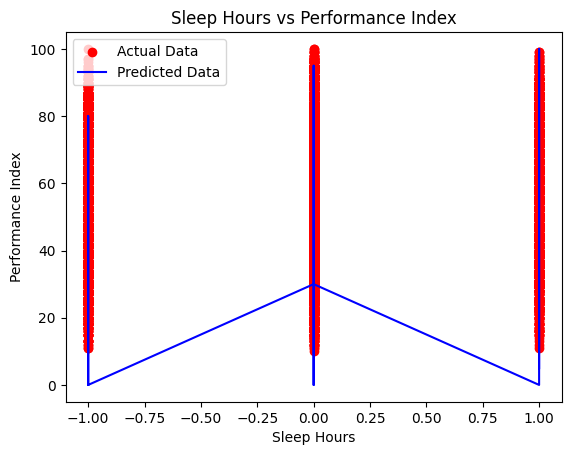

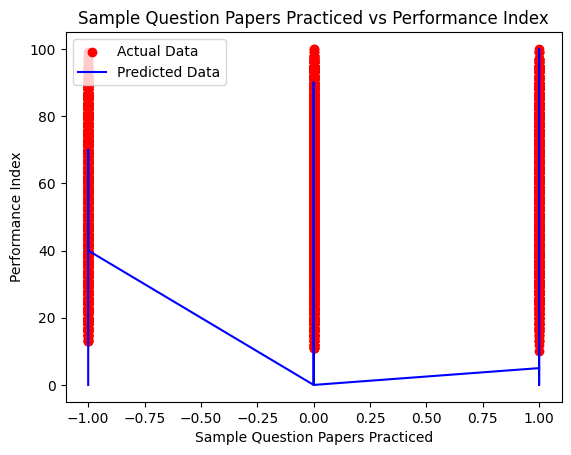

In [10]:
draw_function(x_norm, y_train, f_wb, number_of_features, x_features)

In [11]:
def feature_engineering(x, degree):
    x = x ** degree
    return x

In [ ]:
x_copy = np.copy(x_train)
for i in range(number_of_features):
    x_copy[:,i] = feature_engineering(x_copy[:,i], 2)
print(x_copy[:5, :5])

x_norm_new = z_score_normalization(x_copy, number_of_features)
f_wb_new = compute_f_wb(w_initial, x_norm_new, b_initial, length)
print(f"First 10 predicted values: {f_wb_new[:10]}")
print(f"First 10 actual values:    {y_train[:10]}")

[[  49 9801    1   81    1]
 [  16 6724    0   16    4]
 [  64 2601    1   49    4]
 [  25 2704    1   25    4]
 [  49 5625    0   64   25]]
First 10 predicted values: [40.  0. 15. 15. 10. 25. 15.  0. 10.  5.]
First 10 actual values:    [91. 65. 45. 36. 66. 61. 63. 42. 61. 69.]


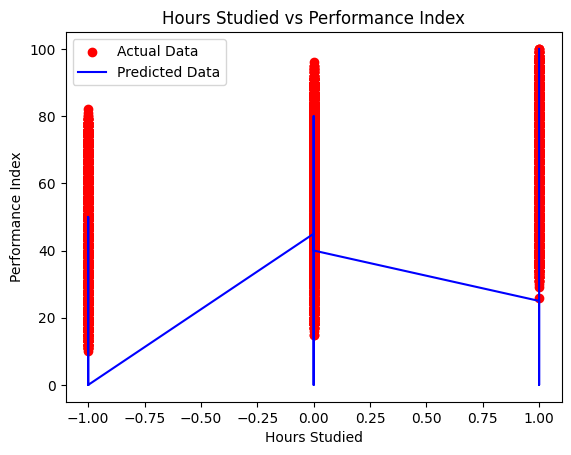

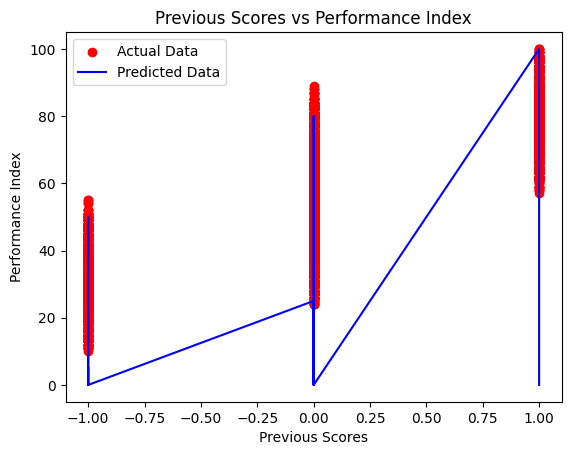

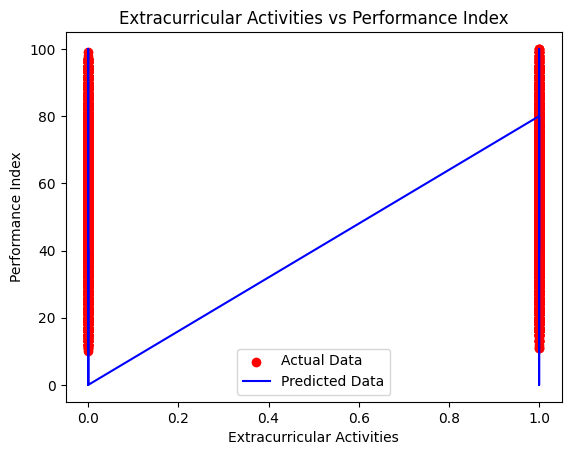

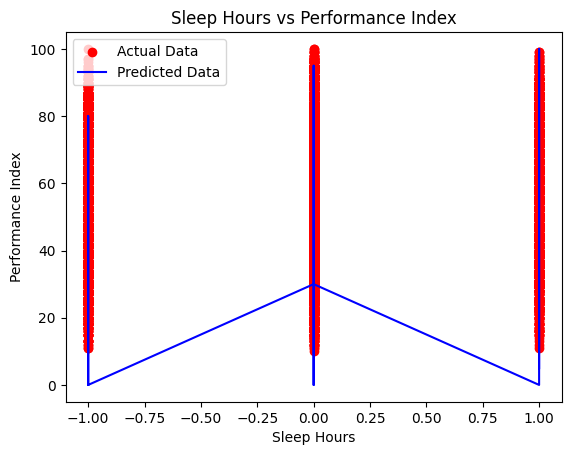

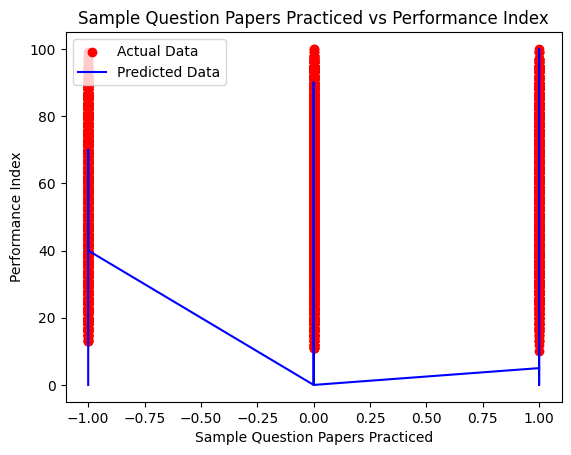

In [13]:
draw_function(x_norm, y_train, f_wb, number_of_features, x_features)

In [14]:
def compute_cost(length, f_wb, y):
    cost = np.sum(np.square(f_wb - y)) / (2 * length)
    return cost

In [17]:
cost_initial = compute_cost(length, f_wb, y_train)
print(f"Initial cost: {cost_initial}")

Initial cost: 748.38425


In [22]:
def compute_dj_dw(x, y, f_wb, length, number_of_features):
    dj_dw = np.zeros(number_of_features)
    for i in range(number_of_features):
        dj_dw[i] = np.sum((f_wb - y) * x[:,i]) / length
    return dj_dw

In [23]:
def compute_dj_db(f_wb, y, length):
    dj_db = np.sum(f_wb - y) / length
    return dj_db

In [50]:
def gradient_descent(x, y, f_wb, w, b, length, number_of_features, alpha):
    number_of_iterations = 1000
    for i in range(number_of_iterations):
        dj_dw = compute_dj_dw(x, y, f_wb, length, number_of_features)
        for j in range(number_of_features):
            w[j] = w[j] - (alpha * dj_dw[j])
        dj_db = compute_dj_db(f_wb, y, length)
        b = b - (alpha * dj_db)
        f_wb = compute_f_wb(w, x, b, length)
    return w, b, f_wb

In [52]:
alpha = 0.01
w, b, f_wb = gradient_descent(x_norm_new, y_train, f_wb_new, w_initial, b_initial, length, number_of_features, alpha)

alpha = 0.001
w, b, f_wb = gradient_descent(x_norm_new, y_train, f_wb, w, b, length, number_of_features, alpha)

cost = compute_cost(length, f_wb, y_train)
print(f"New cost: {cost}")

New cost: 63.05305753809025
